# Analysis

This notebook analyzes and relates data obtained by detecting emotion and events, trying to generate scores for reactions. Also generate plots.

In [3]:
import json # Read stored data

import pandas as pd # Read and manipulate CSV data
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate # Numerical integration

In [4]:
FPS = 25 # Frames per second
last_frame = 6533-1 # Last frame index of the video

## Step 1: Read and process emotion data

- Reads emotion data from the CSV files
- Generates plots
- Check for correlation
- Filter the data using convolution

In [5]:
# Read data from the files

seq_data = []

for i in range(2):
    seq_data.append(pd.read_csv('Emotion/OneManBand-Seq'+str(i+1)+'.csv', 
                            sep=";", 
                            names=["time","valence","arousal","expression"]))

    seq_data[i] = seq_data[i][seq_data[i].time >=0]

In [6]:
# Takes the data and puts it in the main data dictionary

data = {}

data["frame"] = np.ndarray(0)

for i in range(2):
    data["frame"] = np.append(data["frame"], seq_data[i].time.to_numpy()*(FPS))

data["frame"] = np.append(data["frame"], np.arange(0,6533+1,1))
data["frame"].sort()

data["frame"] = np.unique(data["frame"])

n_frame = len(data["frame"])

data["valence"] = []
data["arousal"] = []
data["expression"] = []


for i in range(2):
    df = seq_data[i]

    data["valence"].append(np.ndarray(n_frame))
    data["arousal"].append(np.ndarray(n_frame))
    data["expression"].append(np.ndarray(n_frame, dtype=str))

    line_index = 0

    for j in range(n_frame):
        
        next_line_index = line_index + 1

        if next_line_index == df.shape[0]:
            next_line_index -= 1

        line_row = df.iloc[line_index]
        next_row = df.iloc[next_line_index]

        line_frame = line_row["time"]*FPS
        next_frame = next_row["time"]*FPS

        line_distance = abs(data["frame"][j]-line_frame)
        next_distance = abs(data["frame"][j]-next_frame)

        if line_distance > next_distance:
            line_index += 1

            valence = next_row["valence"]
            arousal = next_row["arousal"]
            expression = next_row["expression"]
        else:
            valence = line_row["valence"]
            arousal = line_row["arousal"]
            expression = line_row["expression"]
        
        
        data["valence"][i][j] = valence
        data["arousal"][i][j] = arousal
        data["expression"][i][j] = expression


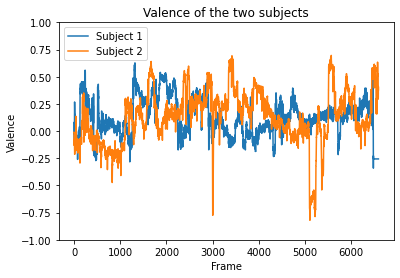

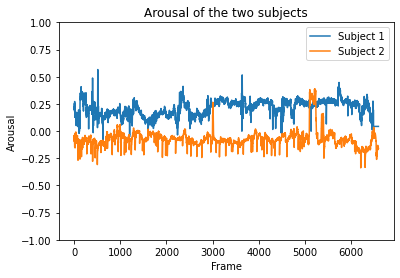

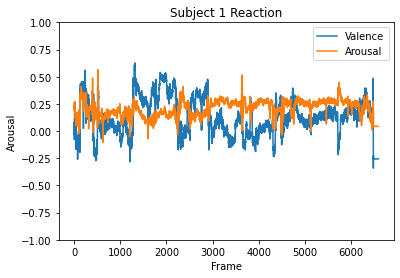

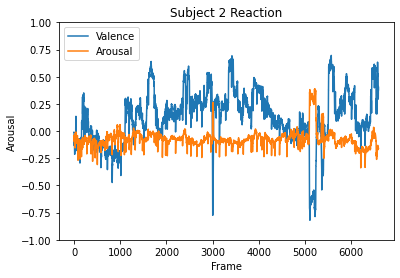

In [213]:
# Generates plots

#Valence
fig = plt.figure()
plt.plot(data["frame"], data["valence"][0])
plt.plot(data["frame"], data["valence"][1])
plt.ylim(-1, 1)

plt.legend(["Subject 1", "Subject 2"])
plt.title("Valence of the two subjects")
plt.ylabel("Valence")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Valence of the two subjects.png",  facecolor='white', transparent=False )


#Arousal
fig = plt.figure()
plt.plot(data["frame"], data["arousal"][0])
plt.plot(data["frame"], data["arousal"][1])
plt.ylim(-1, 1)

plt.legend(["Subject 1", "Subject 2"])
plt.title("Arousal of the two subjects")
plt.ylabel("Arousal")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Arousal of the two subjects.png",  facecolor='white', transparent=False )

#Subjects

for i in range(2):
    fig = plt.figure()
    plt.plot(data["frame"], data["valence"][i])
    plt.plot(data["frame"], data["arousal"][i])
    plt.ylim(-1, 1)

    plt.legend(["Valence", "Arousal"])
    plt.title("Subject "+str(i+1)+" Reaction")
    plt.ylabel("Arousal")
    plt.xlabel("Frame")

    plt.show()
    fig.savefig("Results/Subject "+str(i+1)+" Reaction"+".png",  facecolor='white', transparent=False )


In [6]:
# Checks if the data has correlation (no)

#Correlation

correlation = {}
correlation["Valence between subjects"] = np.corrcoef(data["valence"][0], data["valence"][1])[0][1]
correlation["Arousal between subjects"] = np.corrcoef(data["arousal"][0], data["arousal"][1])[0][1]
correlation["Valence and Arousal of subject 1"] = np.corrcoef(data["arousal"][0], data["valence"][0])[0][1]
correlation["Valence and Arousal of subject 2"] = np.corrcoef(data["arousal"][1], data["valence"][1])[0][1]

print("Correlation")

for key in correlation:
    print(key+":", "{0:.2f}".format(correlation[key]))

correlation_file = open("Results/Correlation.json", "w")
json.dump(correlation, correlation_file)
correlation_file.close()

Correlation
Valence between subjects: 0.00
Arousal between subjects: 0.03
Valence and Arousal of subject 1: -0.06
Valence and Arousal of subject 2: -0.35


In [7]:
# Smooth the data using a Gaussian kernel
# It might take a while. It can probably be optimized using GPU/cuda

data["valence_smoothed"] = []
data["arousal_smoothed"] = []

for i in range(2):
    for dimension in ["valence", "arousal"]:

        smoothed = np.zeros_like(data[dimension][i])
        sigma = 10

        for j in range(data["frame"].shape[0]):
            frame = data["frame"][j]

            kernel = np.exp(-np.power((data['frame']-frame), 2)/(2*np.power(sigma, 2)))
            kernel = kernel / sum(kernel)

            smoothed[j] = np.sum(data[dimension][i] * kernel)

        data[dimension+"_smoothed"].append(smoothed)

        print("Subject "+str(i) + " " + dimension + " smoothed")

Subject 0 valence smoothed
Subject 0 arousal smoothed
Subject 1 valence smoothed
Subject 1 arousal smoothed


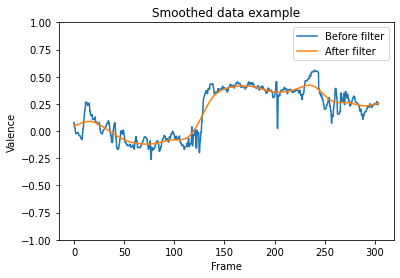

In [211]:
fig = plt.figure()
plt.plot(data["frame"][:1000], data["valence"][0][:1000])
plt.plot(data["frame"][:1000], data["valence_smoothed"][0][:1000])
plt.ylim(-1, 1)

plt.legend(["Before filter", "After filter"])
plt.title("Smoothed data example")
plt.ylabel("Valence")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Example of smoothed data.png",  facecolor='white', transparent=False )

## Step 2: Read and process event data
- Read data from the JSON files
- Join actor appearances in sequential frames in events
- Filter events by duration
- Plot events

In [8]:
# Read the event data

event_file = open('Event/one_man_band_events_filtered.json', 'r')
event_data = json.load(event_file)
event_file.close()

data["actor_presence"] = np.zeros((3, n_frame), bool)
data["actor_action"] = np.ndarray((3, n_frame), dtype='<U39')

for i in range(3):
    for j in range(n_frame):
        frame = data["frame"][j]
        if str(int(frame)) in event_data[str(i)] or (str(np.floor(frame)) in event_data[str(i)] and str(np.ceil(frame)) in event_data[str(i)]):
            data["actor_presence"][i][j] = True
            data["actor_action"][i][j] = event_data[str(i)][str(int(frame))]["action"]

In [9]:
# Create events with appearances in sequential frames

data["event"] = {}

actual_event_id = 0

durations = []

for i in range(3):
    start = -1
    end = -1

    for j in range(n_frame):
        if data["actor_presence"][i][j]:
            if start == -1:
                start = j
        else:
            if start != -1:
                end = j

                durations.append(data["frame"][end] - data["frame"][start])

                event = {}
                event["id"] = actual_event_id
                event["start"] = data["frame"][start]
                event["end"] = data["frame"][end]
                event["actor_id"] = i
                event["action"] = data["actor_action"][i][start]
                
                data["event"][actual_event_id] = event

                actual_event_id += 1

                start = -1

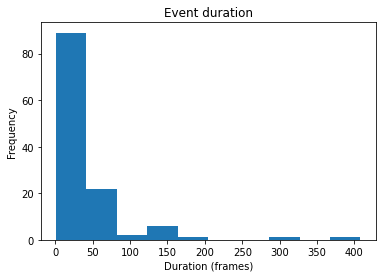

1.00 - 41.70 : 89.0
41.70 - 82.40 : 22.0
82.40 - 123.10 : 2.0
123.10 - 163.80 : 6.0
163.80 - 204.50 : 1.0
204.50 - 245.20 : 0.0
245.20 - 285.90 : 0.0
285.90 - 326.60 : 1.0
326.60 - 367.30 : 0.0
367.30 - 408.00 : 1.0


In [210]:
# Plot the durations histogram to determine the filter threshold

fig = plt.figure()

counts, edges, _ = plt.hist(durations)

plt.title("Event duration")
plt.xlabel("Duration (frames)")
plt.ylabel("Frequency")

plt.show()
fig.savefig("Results/Event duration histogram.png",  facecolor='white', transparent=False )

for i in range(counts.shape[0]):
    print("{0:.2f}".format(edges[i]), "-", "{0:.2f}".format(edges[i+1]), ":", counts[i])

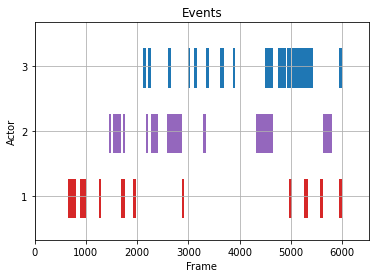

In [208]:
# Plot events before filter

#Plot reference: https://www.geeksforgeeks.org/python-basic-gantt-chart-using-matplotlib/

fig, ax = plt.subplots()

plt.title("Events")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(0, last_frame)

ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

for event_id in data["event"]:
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

   
    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

plt.show()
fig.savefig("Results/Events.png",  facecolor='white', transparent=False )


In [10]:
# Filter events
for event_id in list(data["event"].keys()):
    event = data["event"][event_id]
    

    
    start = event["start"]
    duration = event["end"]-start

    if duration < 40:
      del data["event"][event_id]
        

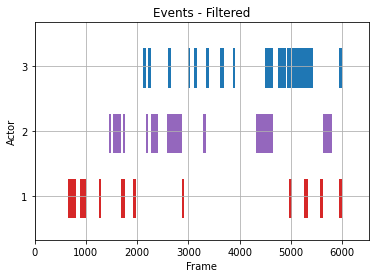

In [207]:
# Plot events after filter

fig, ax = plt.subplots()

plt.title("Events - Filtered")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(0, last_frame)


ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

text_up = [False, False, False]

for event_id in data["event"]:
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

    text_position = line_range[0]-2.5

    if text_up[event["actor_id"]]:
        text_position += 10

    #plt.text(start+(duration/2), text_position, event["action"][0], rotation=0, size=10)
    
    text_up[event["actor_id"]] = not text_up[event["actor_id"]]


plt.show()
fig.savefig("Results/Events - Filtered.png", facecolor='white', transparent=False )

## Step 3: Compute reaction
- Create functions to compute reaction scores (between 0 and 1)
  - Tonic reaction: long reaction 
  - Phasic reaction: fast reaction
- Compute the reaction of every event
  - Also searchs for the biggest reaction of each subject-reaction type-dimension
- Plots visualization of the reactions

In [189]:
# Define the reaction computers

def event_tonic_reaction(event_id, subject):
    '''
        Computes the tonic reaction of a subject to an event

        Integrates the emotion data to compute the reaction

        Parameters:
            event_id (int): ID of the event
            subject (int): ID of the subject
    '''

    # Get event time data
    start = data["event"][event_id]["start"]
    end = data["event"][event_id]["end"]

    # Select the only the emotion and frames in the event
    mask = np.logical_and(data["frame"]>=start, data["frame"]<=end)
    frames = data["frame"][mask]
    valence = data["valence_smoothed"][subject][mask]
    arousal = data["arousal_smoothed"][subject][mask]


    # Select the emotion data around the event
    around_mask = np.logical_and(data["frame"]>=start-50, data["frame"]<=end+50)
    valence_around = data["valence_smoothed"][subject][around_mask]
    arousal_around = data["arousal_smoothed"][subject][around_mask]

    # Get the mean and standard deviation of the valence and arousal around the event
    valence_mean = np.mean(valence_around)
    arousal_mean = np.mean(arousal_around)
    valence_std = np.std(valence_around)
    arousal_std = np.std(arousal_around)
    valence_phi = valence_mean + (valence_std)
    arousal_phi = arousal_mean + (arousal_std)

    # Remove emotion data close to average
    valence[np.logical_and(valence<valence_phi, valence>-valence_phi)] = 0
    arousal[np.logical_and(arousal<arousal_phi, arousal>-arousal_phi)] = 0

    # Compute reaction integrating the emotion data
    valence_reaction = 0
    arousal_reaction = 0

    if valence_std > 0.06:
        valence_reaction = integrate.simps(valence, frames)/(end-start)
    if arousal_std > 0.06:
        arousal_reaction = integrate.simps(arousal, frames)/(end-start)


    return valence_reaction, arousal_reaction

def event_phasic_reaction(event_id, subject):
    '''
        Computes the phasic reaction of a subject to an event

        Search for peaks in the emotion data to compute te reaction

        Parameters:
            event_id (int): ID of the event
            subject (int): ID of the subject
    '''

    # Get event time data
    start = data["event"][event_id]["start"]
    end = data["event"][event_id]["end"]

    # Get the emotion data and frames in the event
    mask = np.logical_and(data["frame"]>=start, data["frame"]<=end)
    frames = data["frame"][mask]
    valence = data["valence_smoothed"][subject][mask]
    arousal = data["arousal_smoothed"][subject][mask]

    # Derive emotion data in the two dimensions
    valence_derivative = np.diff(valence)/np.diff(frames)
    valence_derivative = np.insert(valence_derivative, 0, 0.1)
    
    arousal_derivative = np.diff(arousal)/np.diff(frames)
    arousal_derivative = np.insert(arousal_derivative, 0, 0.1)

    # Get derivatives with a value close to zero (df/dt = 0 -> peak)
    valence_peak_mask = np.abs(valence_derivative) < 1e-3
    arousal_peak_mask = np.abs(arousal_derivative) < 1e-3

    

    valence_peak = valence[valence_peak_mask]
    arousal_peak = arousal[arousal_peak_mask]

    valence_reaction = 0
    arousal_reaction = 0
    
    # Search for the index of the biggest peak
    # and get the reaction = peak
    if valence_peak.shape[0] != 0:
        valence_reaction_index = np.argmax(np.abs(valence_peak))
        valence_reaction = valence_peak[valence_reaction_index]
    if arousal_peak.shape[0] != 0:
        arousal_reaction_index = np.argmax(np.abs(arousal_peak))
        arousal_reaction = arousal_peak[arousal_reaction_index]

    return valence_reaction, arousal_reaction

reaction_computer = {"tonic": event_tonic_reaction, "phasic": event_phasic_reaction}

# Compute the tonic and phasic reaction of every event, with max and min reaction
data["max_reaction"] = {"phasic":{}, "tonic":{}}
data["min_reaction"] = {"phasic":{}, "tonic":{}}

for reaction_type in ["phasic", "tonic"]:
    for dimension in ["valence", "arousal"]:
        data["max_reaction"][reaction_type][dimension] = [{"event_id": 0, "reaction" : 0}, {"event_id": 0, "reaction" : 0}]
        data["min_reaction"][reaction_type][dimension] = [{"event_id": 0, "reaction" : 1}, {"event_id": 0, "reaction" : 1}]

for event_id in data["event"]:
    data["event"][event_id]["tonic_reaction"] = []
    data["event"][event_id]["phasic_reaction"] = []
    
    for subject in range(2):
        for reaction_type in reaction_computer:
            valence_reaction, arousal_reaction = reaction_computer[reaction_type](event_id, subject)
            data["event"][event_id][reaction_type+"_reaction"].append({"valence": valence_reaction, "arousal": arousal_reaction})

            if abs(valence_reaction) > abs(data["max_reaction"][reaction_type]["valence"][subject]["reaction"]):
                data["max_reaction"][reaction_type]["valence"][subject]["reaction"] = valence_reaction
                data["max_reaction"][reaction_type]["valence"][subject]["event_id"] = event_id

            if abs(arousal_reaction) > abs(data["max_reaction"][reaction_type]["arousal"][subject]["reaction"]):
                data["max_reaction"][reaction_type]["arousal"][subject]["reaction"] = arousal_reaction
                data["max_reaction"][reaction_type]["arousal"][subject]["event_id"] = event_id

            if abs(valence_reaction) < abs(data["min_reaction"][reaction_type]["valence"][subject]["reaction"]):
                data["min_reaction"][reaction_type]["valence"][subject]["reaction"] = valence_reaction
                data["min_reaction"][reaction_type]["valence"][subject]["event_id"] = event_id

            if abs(arousal_reaction) < abs(data["min_reaction"][reaction_type]["arousal"][subject]["reaction"]):
                data["min_reaction"][reaction_type]["arousal"][subject]["reaction"] = arousal_reaction
                data["min_reaction"][reaction_type]["arousal"][subject]["event_id"] = event_id

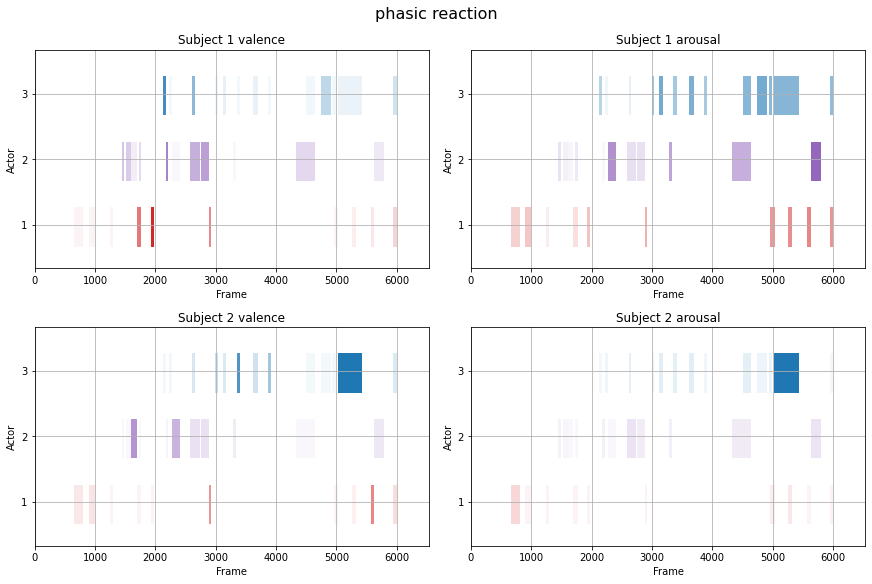

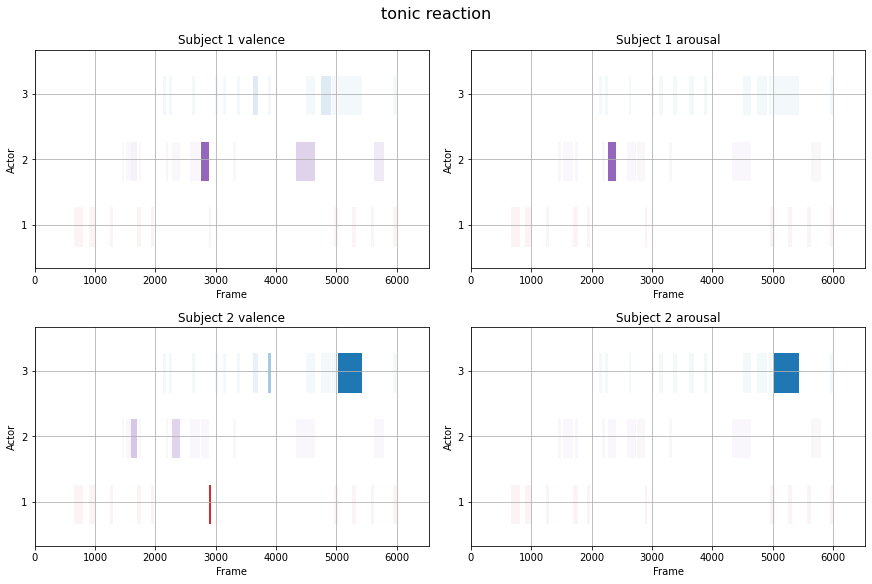

In [192]:
# Plots the phasic reaction
for reaction_type in ["phasic", "tonic"]:

    fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,8))
    for i in range(2): #subject
        for j in range(2): #dimension

            dimension = ["valence", "arousal"][j]

            ax[i][j].set_title("Subject "+str(i+1) + " " + dimension)

            ax[i][j].set_xlabel('Frame')
            ax[i][j].set_ylabel('Actor')

            ax[i][j].set_ylim(0, 50)
            ax[i][j].set_xlim(0, last_frame)

            ax[i][j].set_yticks([10, 25, 40])
            ax[i][j].set_yticklabels(['1', '2', '3'])
            ax[i][j].grid(True)

            for event_id in data["event"]:
                event = data["event"][event_id]
                
                if event["actor_id"] == 0:
                    line_range = (5,9)
                    color = "red"
                elif event["actor_id"] == 1:
                    line_range = (20,9)
                    color = "purple"
                else:
                    line_range = (35,9)
                    color = "blue"
                
                start = event["start"]
                duration = event["end"]-start

                alpha = abs(event[reaction_type+"_reaction"][i][dimension])/abs(data["max_reaction"][reaction_type][dimension][i]["reaction"])
                alpha *= alpha

                ax[i][j].broken_barh([(start, duration)], line_range, facecolors=('tab:'+color), alpha=max(alpha, 0.05))
                

    fig.suptitle(reaction_type+" reaction", fontsize=16)

    plt.show()
    fig.savefig("Results/"+reaction_type+" reaction.png", facecolor='white', transparent=False )

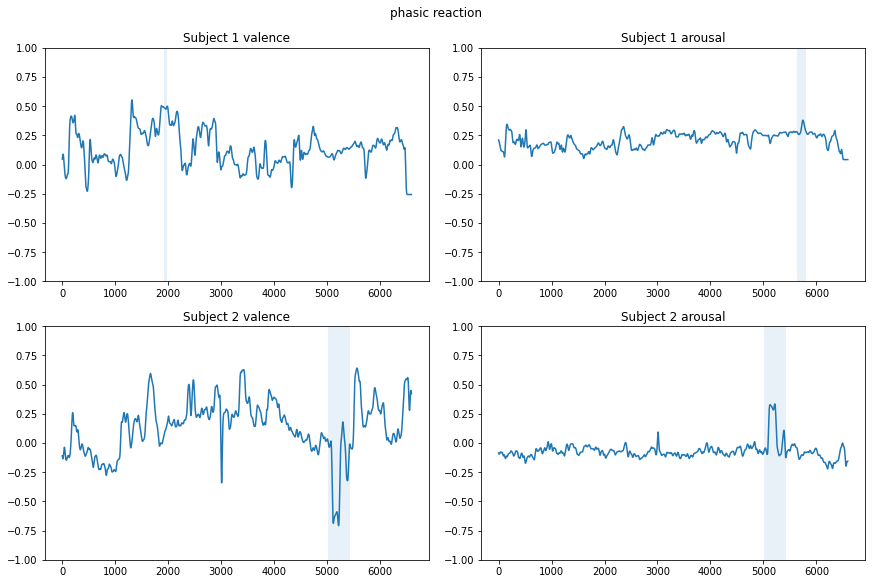

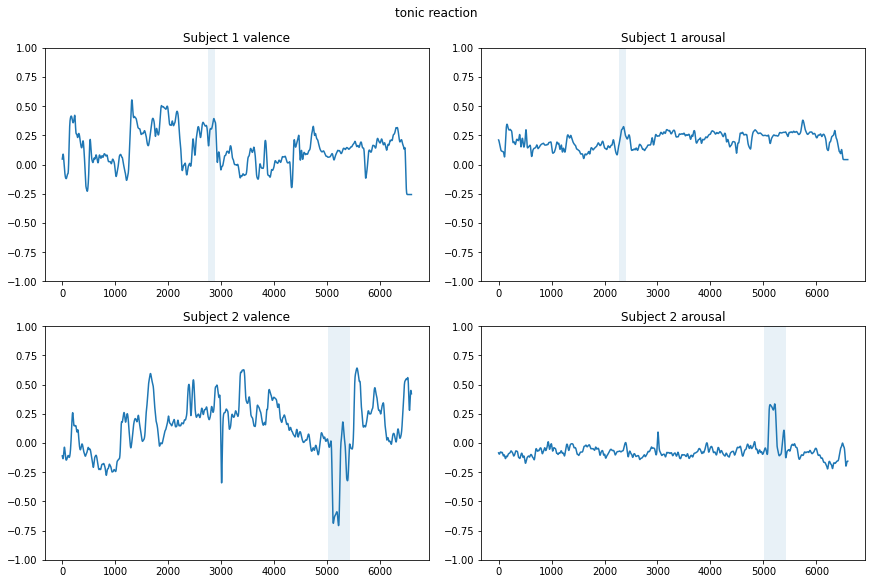

In [217]:
data["max_reaction"]

for reaction_type in ["phasic", "tonic"]:
    fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,8))
    fig.suptitle(reaction_type+" reaction")
    
    for subject in range(2):
        for i in range(2):
            dimension = ["valence", "arousal"][i]

            reaction = data["max_reaction"][reaction_type][dimension][subject]
            event_id = reaction["event_id"]

            event = data["event"][event_id]
            start = event["start"]
            end = event["end"]
            duration = end-start

            # Select the only the emotion and frames in the event
            mask = np.logical_and(data["frame"]>=start-200, data["frame"]<=end+200)
            frames = data["frame"]#[mask]
            emotion = data[dimension+"_smoothed"][subject]#[mask]


            ax[subject][i].plot(frames, emotion)
            ax[subject][i].broken_barh([(start, duration)], (-1,2), alpha=max(alpha, 0.1))
            
            ax[subject][i].set_title("Subject "+str(subject+1) + " " + dimension)
            ax[subject][i].set_ylim(-1,1)
            
    plt.show()
                    

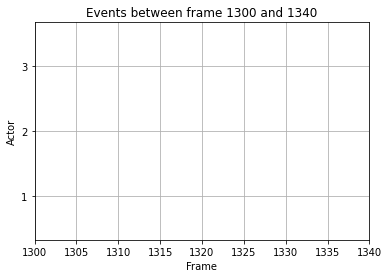

In [215]:
# Plot events in subject 1 valence biggest peak region 

fig, ax = plt.subplots()

plt.title("Events between frame 1300 and 1340")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(1300, 1340)


ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

text_up = [False, False, False]

for event_id in data["event"]:
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

    text_position = line_range[0]-2.5

    if text_up[event["actor_id"]]:
        text_position += 10

    #plt.text(start+(duration/2), text_position, event["action"][0], rotation=0, size=10)
    
    text_up[event["actor_id"]] = not text_up[event["actor_id"]]


plt.show()
fig.savefig("Results/Events between frame 1300 and 1340.png", facecolor='white', transparent=False )

## Step 4: Export data

In [214]:
def encoder(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    
    return obj.__dict__

result_file = open("Results/result.json", "w")
json.dump(data, result_file,  default=lambda o: encoder(o))
result_file.close()

In [265]:
# Export biggest reactions

short_start_time = [7.710, 3.129]

rows = []

for reaction_type in ["phasic", "tonic"]:
    for subject in range(2):
        for dimension in ["valence", "arousal"]:
            reaction_score = data["max_reaction"][reaction_type][dimension][subject]["reaction"]

            event_id = data["max_reaction"][reaction_type][dimension][subject]["event_id"]
            event = data["event"][event_id]
            actor = event["actor_id"]
            start = event["start"]
            end = event["end"]

            start_time = (start/FPS)
            end_time = (end/FPS)

            start_min = int(start_time/60)
            start_sec = start_time%60
            start_string = str(start_min)+":"+str(start_sec)
            
            end_min = int(end_time/60)
            end_sec = end_time%60
            end_string = str(end_min)+":"+str(end_sec)


            subject_start_time = start_time + short_start_time[subject]
            subject_start_min = int(subject_start_time/60)
            subject_start_sec = subject_start_time%60
            subject_start_string = str(subject_start_min)+":"+str(subject_start_sec)

            subject_end_time = end_time + short_start_time[subject]
            subject_end_min = int(subject_end_time/60)
            subject_end_sec = subject_end_time%60
            subject_end_string = str(subject_end_min)+":"+str(subject_end_sec)

            row_data = {"Reaction type": reaction_type, "Dimension": dimension, "Subject": subject+1, 
                        "Reaction score": reaction_score, "Actor": actor+1, 
                        "Start frame": start, "End frame": end, 
                        "Start time (min:s)": start_string, "End time (min:s)": end_string,
                        "Subject start time (min:s)": subject_start_string, "Subject end time (min:s)": subject_end_string,
                        "Event ID": event_id}


            rows.append(row_data)


df = pd.DataFrame(rows)
df.to_csv("Results/Biggest reaction.csv")
df

,Reaction type,Dimension,Subject,Reaction score,Actor,Start frame,End frame,Start time (min:s),End time (min:s),Subject start time (min:s),Subject end time (min:s),Event ID
0,phasic,valence,1,0.499797,1,1928.0,1979.0,1:17.120000000000005,1:19.159999999999997,1:24.83,1:26.86999999999999,10
1,phasic,arousal,1,0.380512,2,5631.0,5796.0,3:45.24000000000001,3:51.84,3:52.95000000000002,3:59.55000000000001,77
2,phasic,valence,2,-0.707039,3,5020.0,5428.0,3:20.80000000000001,3:37.120000000000005,3:23.929000000000002,3:40.248999999999995,115
3,phasic,arousal,2,0.334576,3,5020.0,5428.0,3:20.80000000000001,3:37.120000000000005,3:23.929000000000002,3:40.248999999999995,115
4,tonic,valence,1,0.065677,2,2749.0,2882.0,1:49.959999999999994,1:55.28,1:57.66999999999999,2:2.989999999999995,63
5,tonic,arousal,1,0.114392,2,2273.0,2404.0,1:30.92,1:36.16,1:38.629999999999995,1:43.86999999999999,59
6,tonic,valence,2,-0.256559,3,5020.0,5428.0,3:20.80000000000001,3:37.120000000000005,3:23.929000000000002,3:40.248999999999995,115
7,tonic,arousal,2,0.099218,3,5020.0,5428.0,3:20.80000000000001,3:37.120000000000005,3:23.929000000000002,3:40.248999999999995,115
